In [2]:
# Setup

%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import matplotlib.pyplot as plt
import torch
import numpy as np

# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

Modules to reload:
all-except-skipped

Modules to skip:

5


In [3]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])
    

# Prior and Decoder

In [4]:
single_galaxy_prior = instantiate(cfg.datasets.galsim_blended_std_psf.prior.single_galaxy_prior)
single_star_prior = instantiate(cfg.datasets.galsim_blended_std_psf.prior.single_star_prior)
single_galaxy_decoder = instantiate(cfg.datasets.galsim_blended_std_psf.decoder.single_galaxy_decoder)
single_star_decoder = instantiate(cfg.datasets.galsim_blended_std_psf.decoder.single_star_decoder)

In [5]:
from bliss.models.galsim_decoder import UniformGalsimPrior
prior = UniformGalsimPrior(single_galaxy_prior, single_star_prior, max_n_sources=5, max_shift=0.5, galaxy_prob=0.0)

In [6]:
# check samples look OK 
sample = prior.sample()

# COMMENT OUT for checking what happens when two sources fall in one tile
# sample['locs'][1, :] = sample['locs'][0, :] + 0.01
print(sample)


{'n_sources': tensor(3), 'galaxy_params': tensor([[2.2001e+03, 1.5102e-01, 1.9025e+00, 7.7154e-01, 1.0210e+00, 3.8675e-01,
         8.1769e-01],
        [3.5774e+04, 3.3520e-01, 1.0796e+00, 1.2839e-01, 1.4071e+00, 5.9268e-01,
         2.8919e+00],
        [5.8805e+03, 6.7702e-01, 1.3705e+00, 4.1758e-01, 8.9753e-01, 6.5416e-01,
         8.6885e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00]]), 'star_params': tensor([[  1250.9388],
        [114702.5547],
        [  3397.3267],
        [     0.0000],
        [     0.0000]]), 'locs': tensor([[0.2351, 0.7249],
        [0.9003, 0.0086],
        [0.1804, 0.4273],
        [0.0000, 0.0000],
        [0.0000, 0.0000]]), 'galaxy_bools': tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]), 'star_bools': tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.

In [7]:
# now load full decoder
from bliss.models.galsim_decoder import FullCatelogDecoderSG
slen = 40
bp = 24
decoder = FullCatelogDecoderSG(single_galaxy_decoder, single_star_decoder, slen, bp)

In [8]:
# turn sample to FullCatalog
from bliss.catalog import FullCatalog
params_dict = {**sample}
params_dict["plocs"] = params_dict["locs"] * slen
params_dict.pop('locs')
params_dict = {k: v.unsqueeze(0) for k, v in params_dict.items()}
full_cat = FullCatalog(slen, slen, params_dict)
print(full_cat['galaxy_bools'].shape)
print(full_cat['star_bools'].shape)
print(full_cat.n_sources)

torch.Size([1, 5, 1])
torch.Size([1, 5, 1])
tensor([3])


In [9]:
tile_slen = 4
max_tile_n_sources = 1
tile_cat = full_cat.to_tile_params(tile_slen, max_tile_n_sources, ignore_extra_sources=True)
tile_cat['galaxy_bools'].shape

torch.Size([1, 10, 10, 1, 1])

In [10]:
images, centered, uncentered = decoder(full_cat)

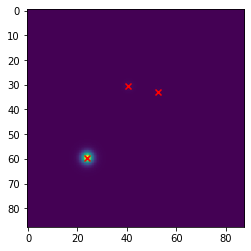

In [11]:
plocs_numpy = full_cat.plocs.numpy()
n_sources = full_cat.n_sources.item()
plt.imshow(images[0].numpy())
plt.scatter(plocs_numpy[0, :n_sources, 1] + decoder.bp - 0.5, plocs_numpy[0, :n_sources, 0] + decoder.bp - 0.5, marker='x', c='r')

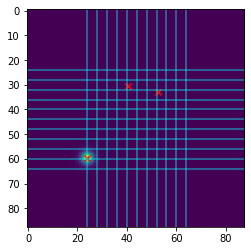

In [12]:
# tiles (blue squares)
plocs_numpy = full_cat.plocs.numpy()
n_sources = full_cat.n_sources.item()
plt.imshow(images[0].numpy())
plt.scatter(plocs_numpy[0, :n_sources, 1] + decoder.bp - 0.5, plocs_numpy[0, :n_sources, 0] + decoder.bp - 0.5, marker='x', c='r')
for x,y in zip(np.arange(0, slen+tile_slen, tile_slen) + bp, np.arange(0, slen+tile_slen, tile_slen) + bp): 
    plt.axvline(x, c='cyan', alpha=0.5)
    plt.axhline(y, c='cyan', alpha=0.5)

In [13]:
tile_cat.n_sources # should correspond to above squares

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [14]:
tile_cat['galaxy_params'][0, :, :, 0, 0] # should correspond to above squares as well

tensor([[    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,  5880.4980,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,  2200.0691,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.

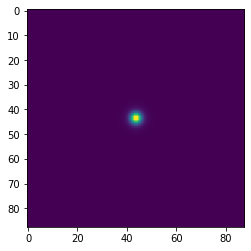

In [15]:
# check images for metrics
plt.imshow(centered[2, 0].numpy())

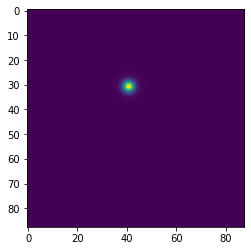

In [16]:
plt.imshow(uncentered[2, 0].numpy())

# Dataset

In [17]:
# now dataset 
from case_studies.psf_homogenization.galsim_blends_sg import GalsimBlendsSGwithPSF
from bliss.datasets.background import ConstantBackground
from case_studies.psf_homogenization.psf_sampler import PsfSampler
background = ConstantBackground((860.,))
psf_sampler = PsfSampler(0.7, 0.9)
ds = GalsimBlendsSGwithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=10, n_batches=3, psf_sampler=psf_sampler, std_psf_fwhm=1.0)

In [27]:
# get one sample from dataset
print(ds[0]['galaxy_bools'].shape)
print(ds[0]['star_params'].shape)
print(ds[0]['n_sources'])
print(ds.max_n_sources)
ds[0]['galaxy_bools'].shape == torch.Size([10, 10, 1, 1])

torch.Size([10, 10, 1, 1])
torch.Size([10, 10, 1, 1])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
5


True

torch.Size([10, 10, 10])
torch.Size([10, 1, 88, 88])
torch.Size([10, 10, 10, 1, 1])
torch.Size([10, 10, 10, 1, 1])

torch.Size([10, 10, 10])
torch.Size([10, 1, 88, 88])
torch.Size([10, 10, 10, 1, 1])
torch.Size([10, 10, 10, 1, 1])

torch.Size([10, 10, 10])
torch.Size([10, 1, 88, 88])
torch.Size([10, 10, 10, 1, 1])
torch.Size([10, 10, 10, 1, 1])



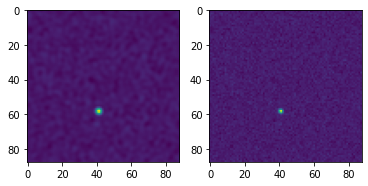

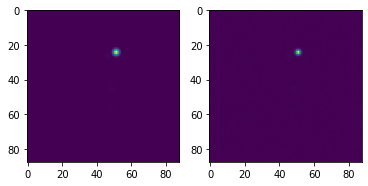

In [19]:
# now a batch and draw example images
for x in ds.train_dataloader():
    print(x['n_sources'].shape)
    print(x['images'].shape)
    print(x['snr'].shape)
    print(x['galaxy_bools'].shape)
    print()
    plt.figure()
    plt.subplot(121)
    plt.imshow(x['images'][0, 0].numpy()) # plot first figure of each batch.
    plt.subplot(122)
    plt.imshow(x['noisy_image'][0, 0].numpy())
plt.close()

In [20]:
# looks like we are ready to go :)